# Мобильное приложение Продукты питания


**Задание:**

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

1. Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. 
Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?


2. После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

## Описание данных <a id="description"></a>

Каждая запись в логе — это действие пользователя, или событие.

* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;
* `EventTimestamp` — время события;
* `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


---

## Общая информация

In [1]:
# подключим необходимые библиотеки и настройки отображения
import pandas as pd
import seaborn as sns
import datetime
import numpy as np
import math as mth
import matplotlib.pyplot as plt
from scipy import stats as st
import plotly.express as px
from plotly import graph_objects as go 

custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', rc=custom_params)

%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', '{:.2f}'.format)


In [2]:
# прочитаем датасет и сохраним в переменную
df = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t')

In [3]:
# посмотрим информацию о датафрейме
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Вывод:**

Датафрейм содержит 244126 записей и 4 столбца (признака). Пропусков значений не обнаружено.

Обнаруженные проблемы:

- Стилистическая ошибка в названиях столбцов и событий (CamelCase)
- Целочисленный тип данных в столбце со временной отметкой
- Целочисленный тип данных в категориальном столбце со значением группы AB-теста

Устраним проблемы на следующем этапе – предобработка данных. 

---

## Подготовка данных

In [4]:
# переименуем столбцы в snake_case
df = df.rename(columns={'DeviceIDHash':'user_id', 'EventName':'event', \
                        'EventTimestamp':'timestamp', 'ExpId':'group'}) 
df.head()

,event,user_id,timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
# переименуем названия событий в snake_case
df['event'] = df['event'].str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True) \
                         .str.lower()
df.head()

,event,user_id,timestamp,group
0,main_screen_appear,4575588528974610257,1564029816,246
1,main_screen_appear,7416695313311560658,1564053102,246
2,payment_screen_successful,3518123091307005509,1564054127,248
3,cart_screen_appear,3518123091307005509,1564054127,248
4,payment_screen_successful,6217807653094995999,1564055322,248


In [6]:
# переведем значения в столбце time в корректный тип данных
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# добавим столбец с датой
df['date'] = df['timestamp'].dt.date

df.head() 

,event,user_id,timestamp,group,date
0,main_screen_appear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,main_screen_appear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,payment_screen_successful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,cart_screen_appear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,payment_screen_successful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [7]:
# зададим функцию для определения группы теста
def group_cat(df):
    group = df['group']
    if group == 246:
        return 'A1'
    if group == 247:
        return 'A2'
    if group == 248:
        return 'B'
    return 'error'


# применим функцию к столбцу и проверим результат
df['group'] = df.apply(group_cat, axis=1)
df.head(10)

,event,user_id,timestamp,group,date
0,main_screen_appear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,main_screen_appear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,payment_screen_successful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,cart_screen_appear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,payment_screen_successful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25
5,cart_screen_appear,6217807653094995999,2019-07-25 11:48:43,B,2019-07-25
6,offers_screen_appear,8351860793733343758,2019-07-25 14:50:42,A1,2019-07-25
7,main_screen_appear,5682100281902512875,2019-07-25 20:14:37,A1,2019-07-25
8,main_screen_appear,1850981295691852772,2019-07-25 20:31:42,A2,2019-07-25
9,main_screen_appear,5407636962369102641,2019-07-26 03:35:12,A1,2019-07-26


In [8]:
# проверим пропуски
df.isna().sum()

event        0
user_id      0
timestamp    0
group        0
date         0
dtype: int64

In [9]:
 # подсчитаем явные дубликаты
df.duplicated().sum() 

413

In [10]:
# удалим явные дубликаты со сбросом индексов таблицы
df = df.drop_duplicates().reset_index(drop=True) 

In [11]:
# проверим количество повторений уникальных user_id в группах
intersection = len(df.groupby('user_id')
                   .agg({'group': 'nunique'})
                   .query('group > 1'))
intersection

0

In [12]:
# результат подготовки данных
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   user_id    243713 non-null  int64         
 2   timestamp  243713 non-null  datetime64[ns]
 3   group      243713 non-null  object        
 4   date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 9.3+ MB


,event,user_id,timestamp,group,date
0,main_screen_appear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,main_screen_appear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,payment_screen_successful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,cart_screen_appear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,payment_screen_successful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25


**Вывод:**

Мы обработали данные и подготовили датафрейм к анализу: переименовали столбцы и названия событий, поменяли тип данных у значений даты и времени события, поменяли значения в столбце с группой теста на категории, добавили новый столбец с датой и проверили на пересечение аудиторий.

Было найдено 413 строк дубликатов – вероятно, они появились из-за технической ошибки. Количество незначительное относительно всего комлекта данных, поэтому мы их удалили. Осталось 243713 строк.

---

## Изучение и проверка данных


Сгруппируем данные по пользователю и количеству совершенных событий:

---



In [13]:
# группировка по пользователю и количеству событий
user_events = df \
    .groupby(['user_id'], as_index=False) \
    .agg({'event' : 'count'}) \
    .rename(columns=({'event' : 'events'})) \
    .sort_values(by='user_id', ascending=True)

user_events

,user_id,events
0,6888746892508752,1
1,6909561520679493,5
2,6922444491712477,47
3,7435777799948366,6
4,7702139951469979,137
...,...,...
7546,9217594193087726423,9
7547,9219463515465815368,17
7548,9220879493065341500,7
7549,9221926045299980007,7


In [14]:
# посмотрим статистики
user_events.describe()

,user_id,events
count,7551.00,7551.00
mean,4677318727102441472.00,32.28
std,2655343100552021504.00,65.15
min,6888746892508752.00,1.00
25%,2397700422051031552.00,9.00
50%,4688021588771745792.00,20.00
75%,7007352523282521088.00,37.00
max,9222603179720523776.00,2307.00


Выведем важные статистики:

In [15]:
# выведем количество событий в логе
total_events = user_events['events'].sum()
print('Наблюдений всего:', total_events)

# выведем количество уникальных пользователей
total_users = user_events['user_id'].nunique()
print('Уникальных пользователей: {} \n---'
      .format(total_users))

# среднее число и мода событий на пользователя
print('Среднее число событий на пользователя: {} \
      \nМедиана числа событий на пользователя: {} \
      \nМода числа событий на пользователя: {} \
      \n---'\
      .format(int(user_events['events'].mean()),
              int(user_events['events'].median()),
              int(user_events['events'].mode())))

# минимальное и максимальное числособытий на пользователя
print('Минимальное число событий на пользователя: {} \
      \nМаксимальное число событий на пользователя: {} \
      \n---'\
      .format(int(user_events['events'].min()),
              int(user_events['events'].max())))

# крайние даты событий
print('Начало отслеживания событий: {} \nКонец отслеживания событий: {}'\
      .format(df['date'].min(), df['date'].max()))

Наблюдений всего: 243713
Уникальных пользователей: 7551 
---
Среднее число событий на пользователя: 32       
Медиана числа событий на пользователя: 20       
Мода числа событий на пользователя: 5       
---
Минимальное число событий на пользователя: 1       
Максимальное число событий на пользователя: 2307       
---
Начало отслеживания событий: 2019-07-25 
Конец отслеживания событий: 2019-08-07


Видим большой разброс количества событий на пользователя, отфильтруем их до 100, чтобы посмотреть ближе без аномально больших значений, оценим распределение на графике:

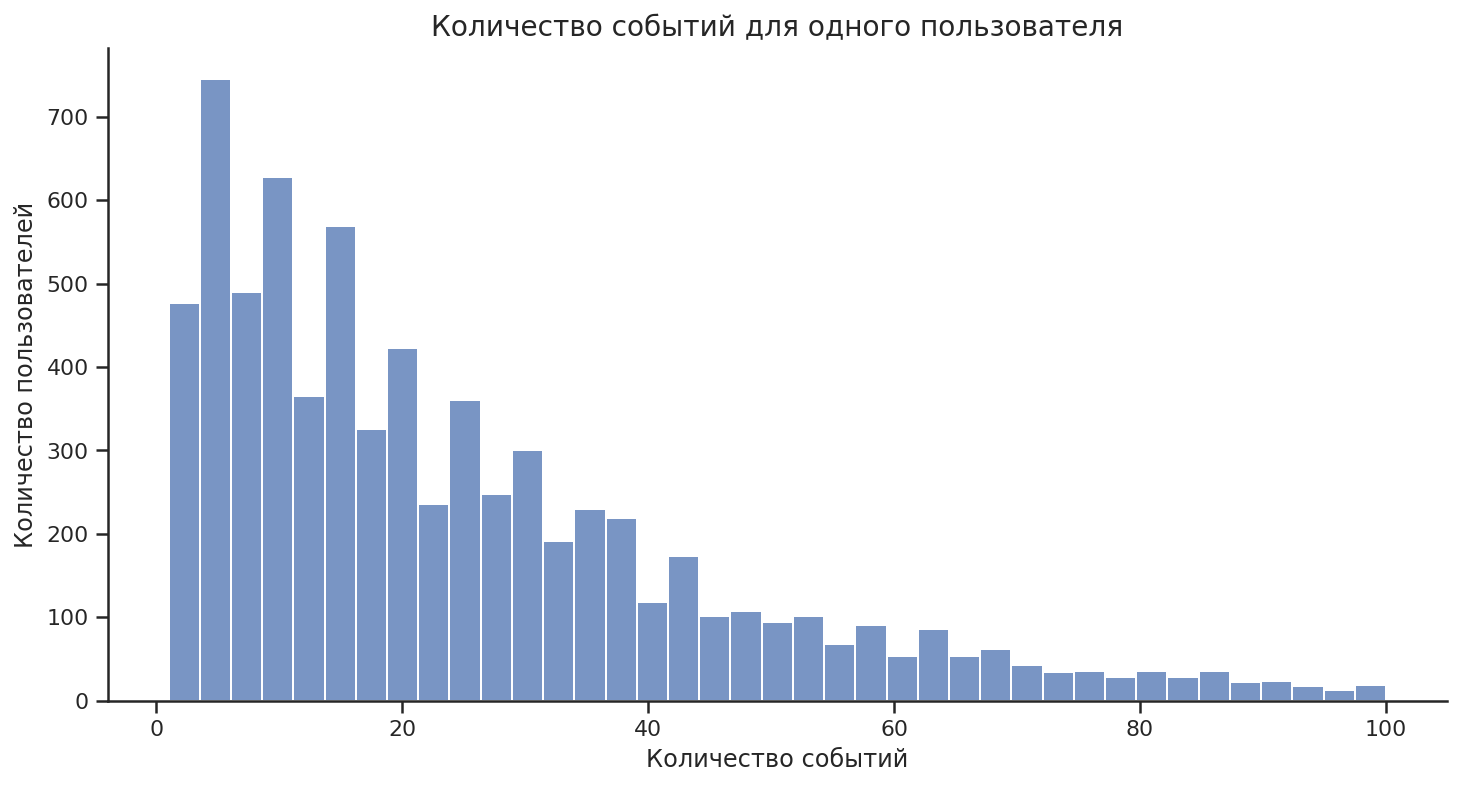

In [16]:
# построим гистограмму для визуализации числа событий на пользователя
plt.figure(figsize=(12,6))

sns.histplot(data=user_events, x=user_events.query('0 < events <= 100')['events']);
plt.title('Количество событий для одного пользователя', fontsize=14);
plt.xlabel('Количество событий');
plt.ylabel('Количество пользователей');

Вывод: выделяется мода, а основная часть событий состредоточена в диапазоне до 40.

Построим гистограмму по дате и времени:

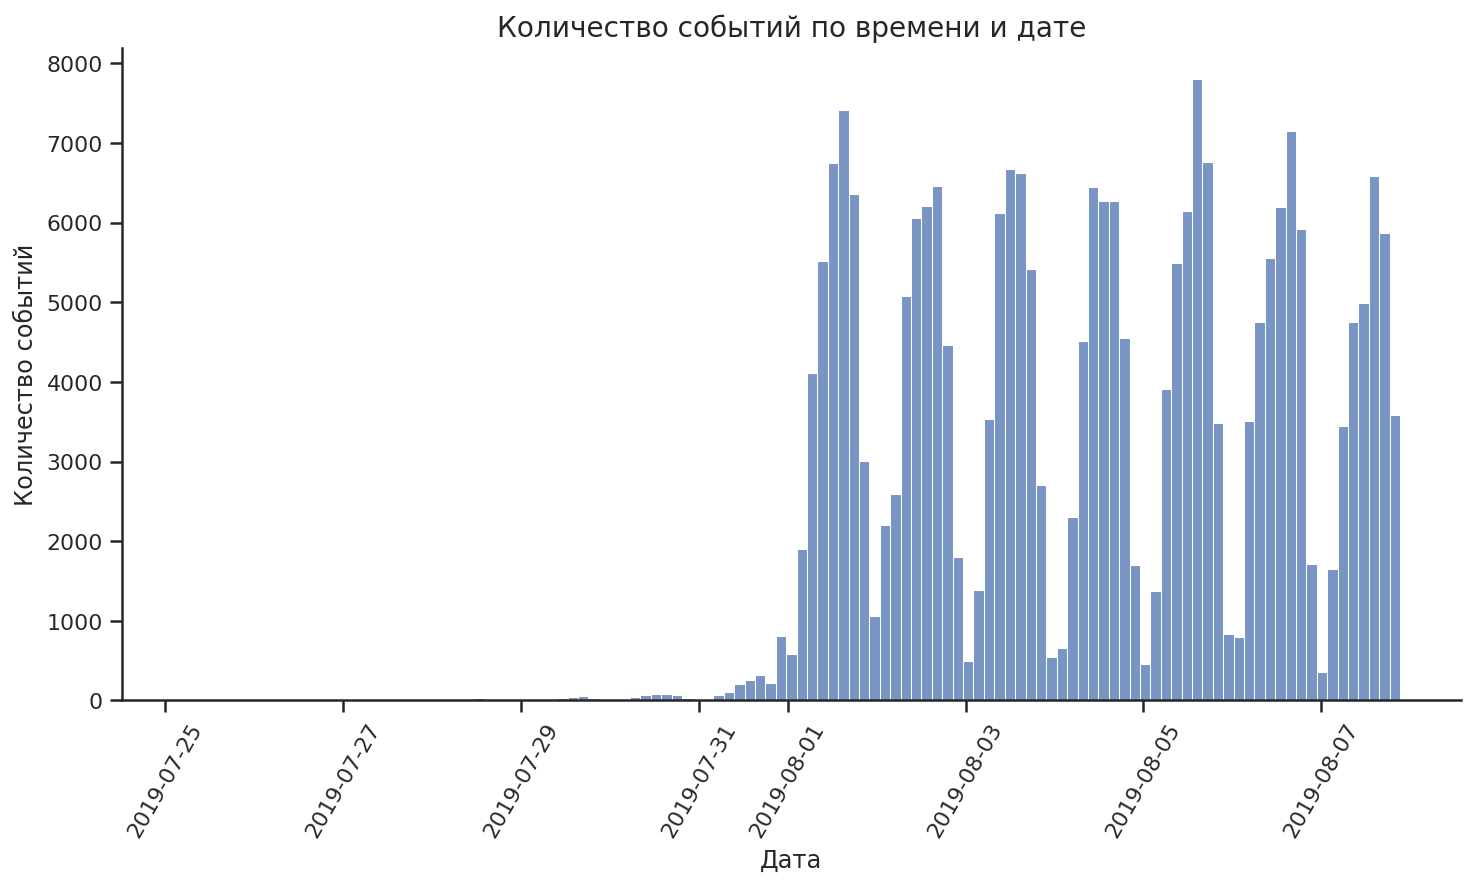

In [17]:
# построим гистограмму для визуализации по времени и дате
plt.figure(figsize=(12,6))

sns.histplot(data=df, x=df['timestamp']);
plt.title('Количество событий по времени и дате', fontsize=14);
plt.xlabel('Дата');
plt.xticks(rotation=60);
plt.ylabel('Количество событий');

In [18]:
# сгруппируем данные по дате и количеству событий
events_by_date = df \
    .groupby(['date'], as_index=False) \
    .agg({'timestamp' : 'count'}) \
    .rename(columns=({'timestamp' : 'events'})) \
    .sort_values(by='date', ascending=True)

events_by_date

,date,events
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


Видим, что у нас есть данные за 2 недели, но на первой неделе было мало событий.

Полные данные отслеживаются с 2019-08-01 по 2019-08-07 – за 7 дней.

Посчитаем, много ли событий и пользователей мы потеряли, отбросив старые данные:

In [19]:
# создадим копию датафрейма с очищенными по дате данными
date_threshold = datetime.date(2019, 8, 1)
df_filtered = df.query('date >= @date_threshold').reset_index()

total_events_filtered = len(df_filtered)
total_users_filtered = df_filtered['user_id'].nunique()
df_filtered.head()

,index,event,user_id,timestamp,group,date
0,2826,tutorial,3737462046622621720,2019-08-01 00:07:28,A1,2019-08-01
1,2827,main_screen_appear,3737462046622621720,2019-08-01 00:08:00,A1,2019-08-01
2,2828,main_screen_appear,3737462046622621720,2019-08-01 00:08:55,A1,2019-08-01
3,2829,offers_screen_appear,3737462046622621720,2019-08-01 00:08:58,A1,2019-08-01
4,2830,main_screen_appear,1433840883824088890,2019-08-01 00:08:59,A2,2019-08-01


In [20]:
print('Количество событий до фильтрации: {}, после: {}. \nРазница: {} ({}%)' \
      .format(total_events, total_events_filtered, \
              total_events - total_events_filtered, \
              round(100 - total_events_filtered / total_events * 100, 2)))
print('Количество пользователей до фильтрации: {}, после: {}. \nРазница: {} ({}%)' \
      .format(total_users, total_users_filtered, \
              total_users - total_users_filtered, \
              round(100 - total_users_filtered / total_users * 100, 2)))

Количество событий до фильтрации: 243713, после: 240887. 
Разница: 2826 (1.16%)
Количество пользователей до фильтрации: 7551, после: 7534. 
Разница: 17 (0.23%)


Проверим, что у нас есть пользователи из всех трёх экспериментальных групп:

In [21]:
# подсчитаем количество событий в каждой экспериментальной группе оригинального датафрейма
df_users = df.groupby('group')['event'].count()
df_users

group
A1    80181
A2    77950
B     85582
Name: event, dtype: int64

In [22]:
# подсчитаем количество событий в каждой экспериментальной группе отфильтрованного датафрейма
df_filtered_groups = df_filtered.groupby('group')['event'].count()
df_filtered_groups

group
A1    79302
A2    77022
B     84563
Name: event, dtype: int64

In [23]:
# расссчитаем потери данных относительно оригинального датафрейма
delta_a1 = df_users[0] - df_filtered_groups[0]
delta_a2 = df_users[1] - df_filtered_groups[1]
delta_b = df_users[2] - df_filtered_groups[2]


print('Потери в группах относительно оригинального датафрейма: \
       \nA1: {} ({}%) \nA2: {} ({}%) \nB: {} ({}%)' \
      .format(delta_a1, round(delta_a1 / df_users[0] * 100, 2), \
              delta_a2, round(delta_a2 / df_users[1] * 100, 2), \
              delta_b, round(delta_b / df_users[2] * 100, 2)))

Потери в группах относительно оригинального датафрейма:        
A1: 879 (1.1%) 
A2: 928 (1.19%) 
B: 1019 (1.19%)


**Вывод:**

Мы изучили и проверили данные. 

В начальном датафрейме имеются данные за 14 дней, но только 7 дней подходят для анализа, так как содержат полные данные. Мы собрали новый датафрейм с отфильтрованными данными с даты, когда события стали поступать полноценно.

Мы проверили процент потерь данных – он оказался незначительным (не более 1.2%). Потери в тестовых группах также небольшие.

Можно приступать к работе с отфильтрованным датафреймом.

---

## Изучение воронки событий


Посмотрим, какие события есть в логах, как часто они встречаются. 

Отсортируем события по частоте:

In [24]:
# сгруппируем данные событиям с сортировкой по частоте
events_count = df_filtered \
              .groupby(['event']) \
              .agg({'timestamp' : 'count'}) \
              .rename(columns=({'timestamp' : 'total_events'})) \
              .sort_values(by='total_events', ascending=False) \
              .reset_index()
              
events_count

,event,total_events
0,main_screen_appear,117328
1,offers_screen_appear,46333
2,cart_screen_appear,42303
3,payment_screen_successful,33918
4,tutorial,1005


Всего имеется 5 типов событий. Самое частое – `main_screen_appear`.

Посчитаем, сколько пользователей совершали каждое из этих событий. 

Отсортируем события по числу пользователей. 

Посчитаем долю пользователей, которые хоть раз совершали событие.

In [25]:
# сгруппируем данные по событиям и количеству пользователей с сортировкой
events_by_users = df_filtered \
    .groupby(['event']) \
    .agg({'user_id' : 'nunique'}) \
    .rename(columns=({'user_id' : 'total_users'})) \
    .sort_values(by='total_users', ascending=False) \
    .reset_index()

# добавим столбцы с процентными соотношениями шагов воронки
events_by_users['percent_initial'] = events_by_users['total_users'] \
    .apply(lambda x: (x/events_by_users['total_users'][0]*100))

events_by_users['percent_previous'] = (events_by_users['total_users'] \
                                            / events_by_users['total_users'].shift() * 100)
events_by_users['percent_previous'][0]=100
events_by_users['percent_previous']=events_by_users['percent_previous']

events_by_users['percent_total'] = events_by_users['total_users'] \
    .apply(lambda x: (x/total_users*100))


events_by_users

,event,total_users,percent_initial,percent_previous,percent_total
0,main_screen_appear,7419,100.00,100.00,98.25
1,offers_screen_appear,4593,61.91,61.91,60.83
2,cart_screen_appear,3734,50.33,81.30,49.45
3,payment_screen_successful,3539,47.70,94.78,46.87
4,tutorial,840,11.32,23.74,11.12


Изучим воронку событий:

In [26]:
# построим интерактивную воронку событий
fig = go.Figure(
    go.Funnel(
        y=events_by_users['event'].unique(),
        x=events_by_users['total_users'].unique(),
        textposition = 'inside',
        textinfo = 'value+percent initial+percent previous+percent total')
    )

fig.update_layout(
    autosize=False,
    width=1100,
    height=600,
    title='Воронка всех событий с расчетом доли шагов')

fig.show() 

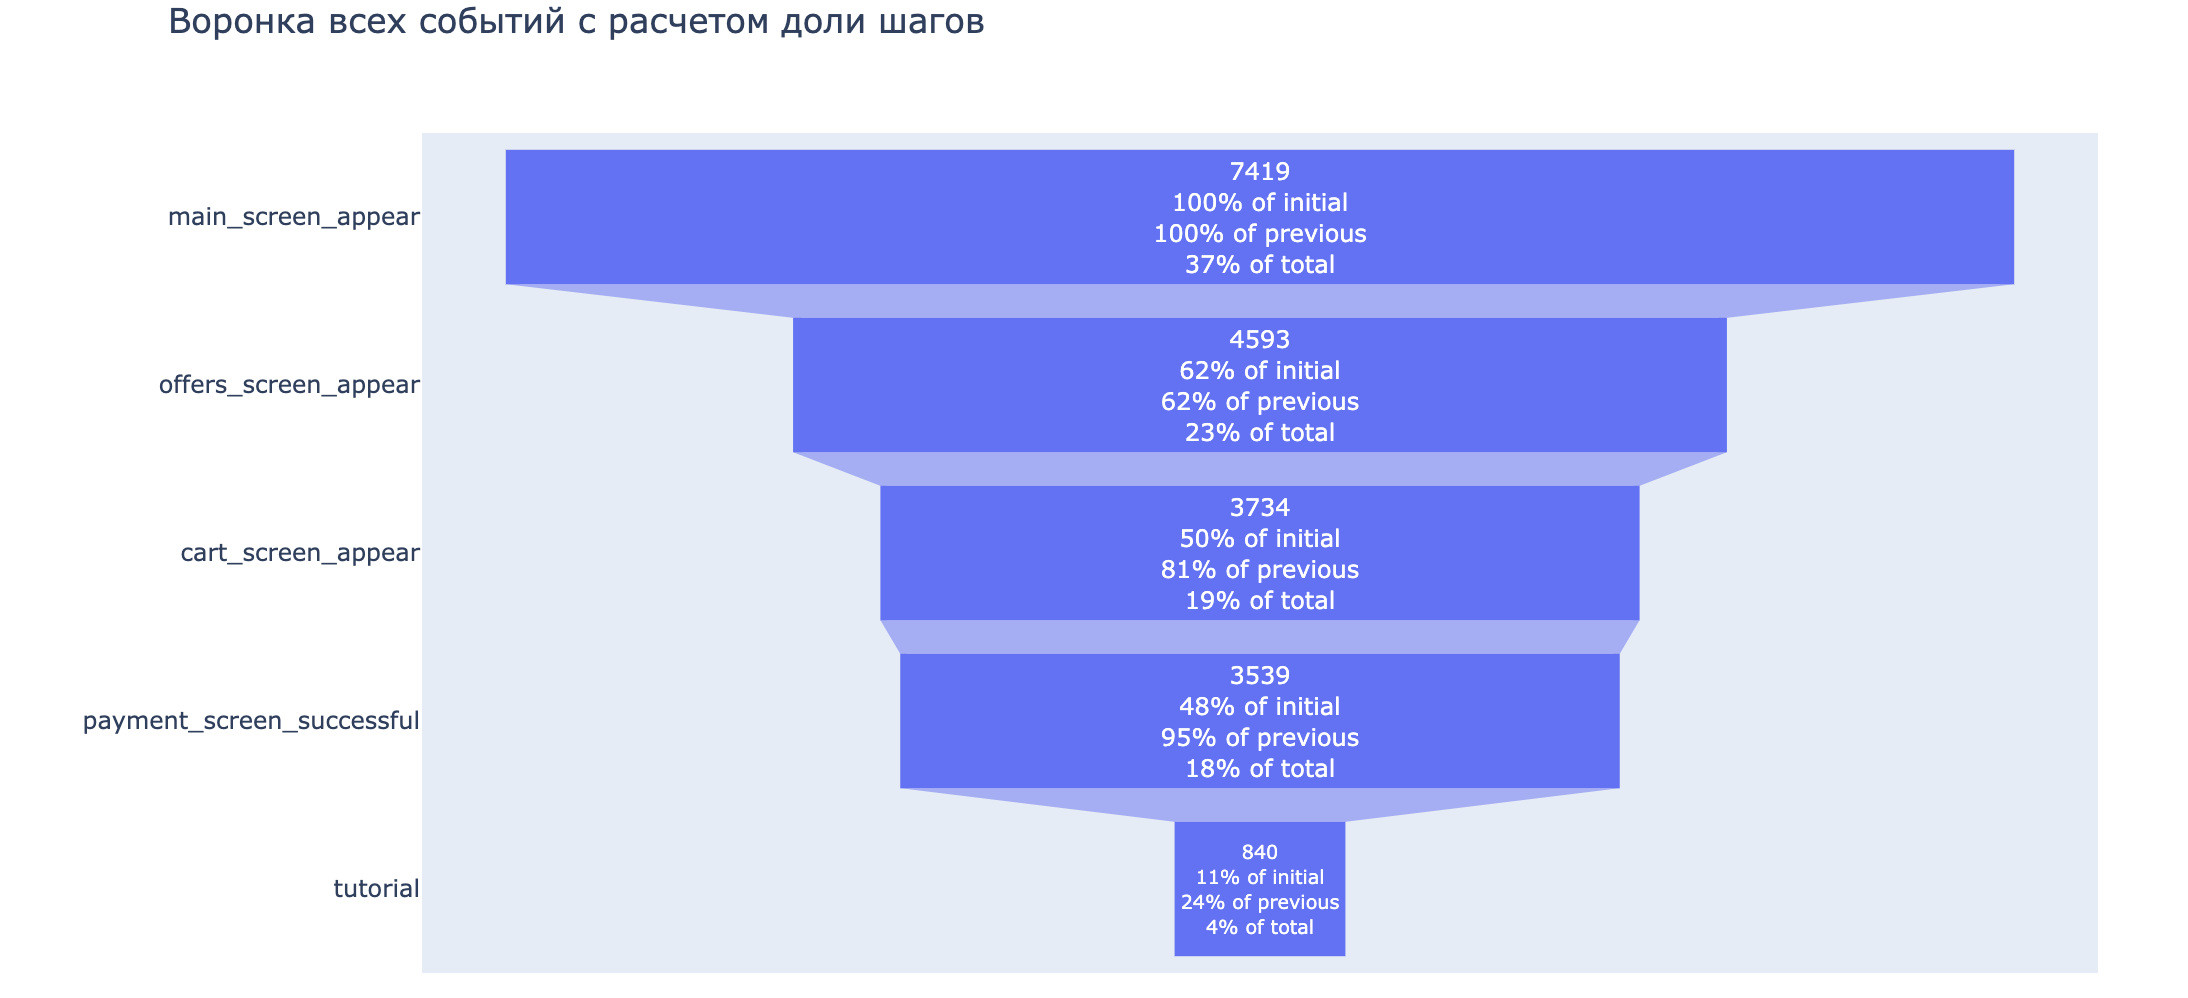

Предположим, что последовательность событий для пользователя может быть такой:

1. `main_screen_appear` – показ главного экрана приложения
2. `tutorial` – прохождение (завершение?) обучалки (онбординг приложения, который можно пропустить)
3. `offers_screen_appear` – показ экрана со спецпредложением
4. `cart_screen_appear` – показ корзины
5. `payment_screen_successful` – показ экрана успешной оплаты заказа


Записи со срабатыванием события `tutorial` можно исключить из анализа, так как оно не является обязательным для оценки конверсии и, судя по количеству срабатываний, его часто пропускают.

По воронке событий можно увидеть, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

Для просмотра отфильтрум датасет от события `tutorial` и просмотрим оставшиеся шаги:

In [27]:
# исключим события tutorial из датафрейма
df_final = df_filtered.query('event != "tutorial"').reset_index()

# обновим расчет воронки
events_by_users = df_final \
    .groupby(['event']) \
    .agg({'user_id' : 'nunique'}) \
    .rename(columns=({'user_id' : 'total_users'})) \
    .sort_values(by='total_users', ascending=False) \
    .reset_index()

# построим интерактивную воронку с выводом процента от предыдущего шага
fig = go.Figure(
    go.Funnel(
        y=events_by_users['event'].unique(),
        x=events_by_users['total_users'].unique(),
        textposition = 'inside',
        textinfo = 'value+percent initial+percent previous+percent total',
        marker = {'color': 'indigo'}
    ))

fig.update_layout(
    autosize=False,
    width=1100,
    height=600,
    title='Воронка анализируемых событий с расчетом доли шагов')

fig.show()


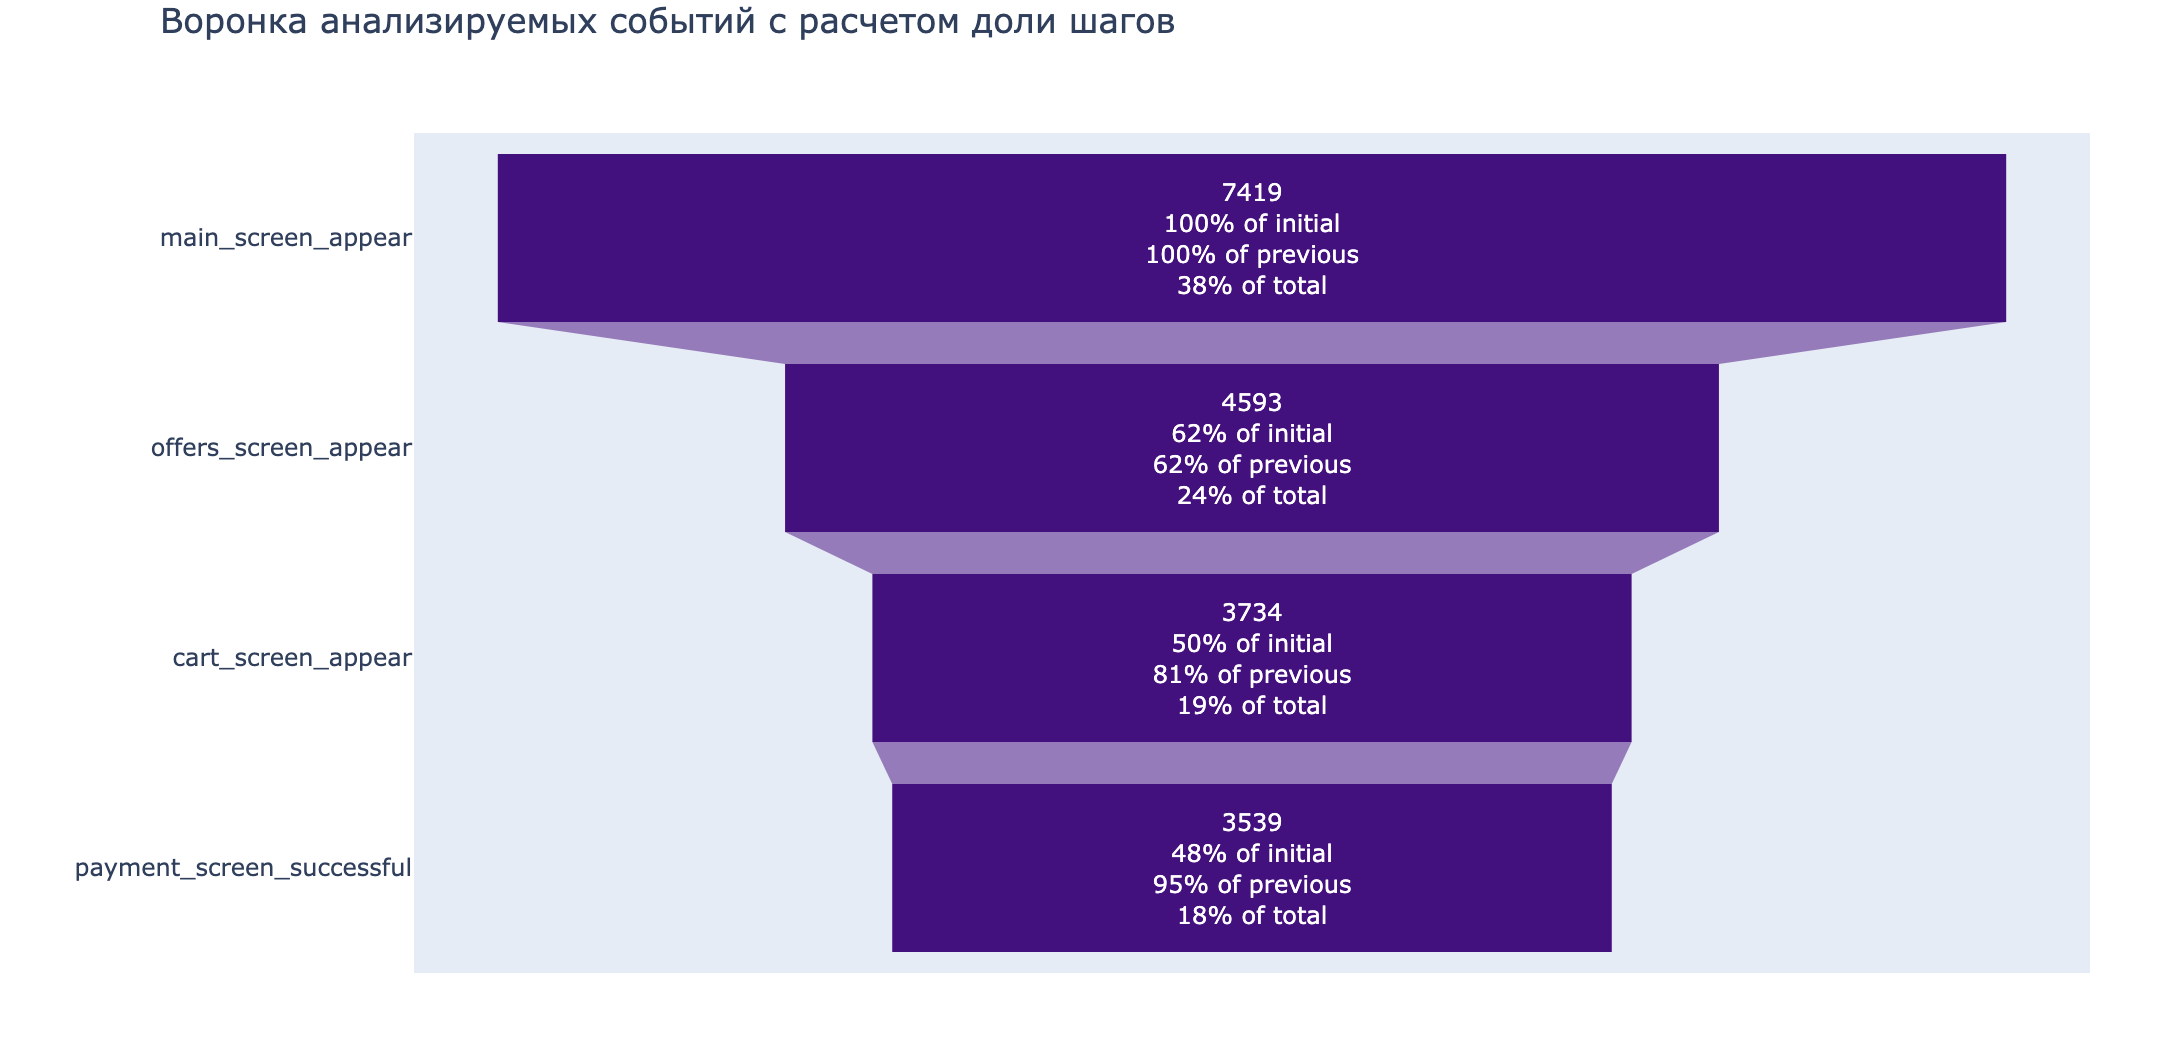

**Вывод по шагу:**

- Всего имеется 5 типов событий. Самое частое – `main_screen_appear`. Самое редкое – `tutorial` (исключено из анализа)
- Больше всего пользователей приложение теряет на переходе с шага `main_screen_appear` на шаг `offers_screen_appear`: всего 62% после просмотра главного экрана увидели экран спецпредложения
- При этом целых 48% пользователей доходит до шага `payment_screen_successful` (Оплата) – это хороший показатель конверсии.

---

## Изучение результатов эксперимента

Узнаем, сколько пользователей есть в каждой экспериментальной группе:


In [28]:
# группируем пользователей по группам
ab_users = df_final \
    .groupby(['group']) \
    .agg({'user_id' : 'nunique'}) \
    .rename(columns=({'user_id' : 'group_users'}))

ab_users

,group_users
group,
A1,2483
A2,2512
B,2535


Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. 

Проверим, находят ли статистические критерии разницу между выборками A1 и A2.

Посчитаем число пользователей, совершивших каждое из событий в каждой из контрольных групп. 

Добавим в таблицу долю пользователей, совершивших это событие в данной группе:

In [29]:
# сгруппируем пользователей по событиям и группам
ab_events = df_final \
    .groupby(['event', 'group'], as_index=False) \
    .agg({'user_id' : 'nunique'}) \
    .rename(columns=({'user_id' : 'total_users'}))
    
# объединим датасеты, добавив столбец с общим количеством в группе
ab_events = ab_events.merge(ab_users.reset_index(), how='inner', on='group')

# добавим столбец с долей от всех пользователей группы
ab_events['percent_of_group'] = (ab_events['total_users'] / ab_events['group_users']*100)

# удалим столбец, он больше не нужен   
ab_events = ab_events.drop(['group_users'], axis=1)
ab_events

,event,group,total_users,percent_of_group
0,cart_screen_appear,A1,1266,50.99
1,main_screen_appear,A1,2450,98.67
2,offers_screen_appear,A1,1542,62.10
3,payment_screen_successful,A1,1200,48.33
4,cart_screen_appear,A2,1238,49.28
5,main_screen_appear,A2,2476,98.57
6,offers_screen_appear,A2,1520,60.51
7,payment_screen_successful,A2,1158,46.10
8,cart_screen_appear,B,1230,48.52
9,main_screen_appear,B,2493,98.34


In [30]:
#ячейка ревьюера
for i in ab_events.index:
    if ab_events.loc[i,'group'] == 'A2':
        print(ab_events.loc[i,'total_users']/ab_users.loc['A2','group_users'])

0.4928343949044586
0.9856687898089171
0.6050955414012739
0.4609872611464968


Проверим, будет ли отличие между группами статистически достоверным.

Обернем проверку в отдельную функцию: 

In [31]:
# создадим список событий
event_name = ['payment_screen_successful', 'cart_screen_appear', \
             'offers_screen_appear', 'main_screen_appear']

# зададим функцию для проверки гипотезы для двух групп
def event_diff_check(test_users, test_events, group_1, group_2):

    
    alpha = .05 # критический уровень статистической значимости

    for name in event_name:
        # рассчитываемое событие
        successes = np.array([int(test_events.query('group == @group_1 \
                              & event == @name')['total_users']),\
                              int(test_events.query('group == @group_2 \
                              & event == @name')['total_users'])])

        # все события
        trials = np.array([test_users.loc[group_1, 'group_users'],\
                           test_users.loc[group_2, 'group_users']])

        # пропорция успехов в первой группе
        p1 = successes[0]/trials[0]

        # пропорция успехов во второй группе
        p2 = successes[1]/trials[1]

        # пропорция успехов в комбинированном датасете
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) \
                                        * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('\nГруппы: {} и {}\
        \np-значение: {}'.format(group_1, group_2, p_value.round(2)))

        if (p_value < alpha):
            print('Событие: {}\
            \nОтвергаем нулевую гипотезу. \n---'\
                  .format(name))
        else:
            print('Событие: {} \
            \nНе получилось отвергнуть нулевую гипотезу. \n---'\
                  .format(name))

In [32]:
# задаем уровень статистической значимости
alpha = .05 

# задаем универсальную функцию для статистического теста 
def z_test (successes1, successes2, trials1, trials2):
    
    # пропорция успехов в первой группе
    p1 = successes1/trials1

    # пропорция успехов во второй группе
    p2 = successes2/trials2

    # пропорция успехов в комбинированном датасете
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)

    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Теперь сформулируем гипотезу и проверим контрольные группы.

### Гипотеза: статистически значимых различий после смены шрифта между группами нет.

- $H_0$: доли пользователей в группах A1 и A2 равны
- $H_1$: доли пользователей в группах A1 и A2 отличаются

In [33]:
# запускаем функцию для расчета
event_diff_check(ab_users, ab_events, 'A1', 'A2')


Группы: A1 и A2        
p-значение: 0.11
Событие: payment_screen_successful             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: A1 и A2        
p-значение: 0.23
Событие: cart_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: A1 и A2        
p-значение: 0.25
Событие: offers_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: A1 и A2        
p-значение: 0.75
Событие: main_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---


При расчете с критическим уровнем статистической значимости в 5% у групп A1 и A2 получились примерно одинаковые результаты.

Гипотеза о равенстве групп подтвердилась. 

**Вывод:** мы проверили контрольную группу и не обнаружили статистически значимой разницы между двумя группами пользователей – нет оснований считать доли разными.

Аналогично поступим с группой с изменённым шрифтом (B). 

Сравним результаты с каждой из контрольных групп в отдельности по каждому событию:


### Проверка в группах A1 и B

- $H_0$: доли пользователей в группах A1 и B равны
- $H_1$: доли пользователей в группах A1 и B отличаются

In [34]:
# запускаем функцию для расчета
event_diff_check(ab_users, ab_events, 'A1', 'B')


Группы: A1 и B        
p-значение: 0.22
Событие: payment_screen_successful             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: A1 и B        
p-значение: 0.08
Событие: cart_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: A1 и B        
p-значение: 0.21
Событие: offers_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: A1 и B        
p-значение: 0.34
Событие: main_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---


При расчете с критическим уровнем статистической значимости в 5% у контрольных групп A1 и B получились примерно одинаковые результаты.

Гипотеза о равенстве групп подтвердилась. 

**Вывод:** для групп A1 и В нет оснований считать доли разными.

### Проверка в группах A2 и B

- $H_0$: доли пользователей в группах A2 и B равны
- $H_1$: доли пользователей в группах A2 и B отличаются

In [35]:
# запускаем функцию для расчета
event_diff_check(ab_users, ab_events, 'A2', 'B')


Группы: A2 и B        
p-значение: 0.73
Событие: payment_screen_successful             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: A2 и B        
p-значение: 0.59
Событие: cart_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: A2 и B        
p-значение: 0.93
Событие: offers_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: A2 и B        
p-значение: 0.52
Событие: main_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---


При расчете с критическим уровнем статистической значимости в 5% у групп A2 и B получились примерно одинаковые результаты.

Гипотеза о равенстве групп подтвердилась. 

**Вывод:** для групп A2 и В нет оснований считать доли разными.

Сравним результаты с объединённой контрольной группой:

In [36]:
# создадим таблицу с комбинированной группой AA
aab_users = df_final \
    .groupby(['group'], as_index=False) \
    .agg({'user_id' : 'nunique'}) \
    .rename(columns=({'user_id' : 'group_users'}))

aab_users['group'] = ['AA','AA','B']
aab_users = aab_users.groupby('group').sum()
aab_users

,group_users
group,
AA,4995
B,2535


In [37]:
# создадим таблицу по событиям для двух групп
aab_events = df_final.replace({'A1':'AA', 'A2':'AA'}) \
    .groupby(['event', 'group'], as_index=False) \
    .agg({'user_id' : 'nunique'}) \
    .rename(columns=({'user_id' : 'total_users'}))

aab_events

,event,group,total_users
0,cart_screen_appear,AA,2504
1,cart_screen_appear,B,1230
2,main_screen_appear,AA,4926
3,main_screen_appear,B,2493
4,offers_screen_appear,AA,3062
5,offers_screen_appear,B,1531
6,payment_screen_successful,AA,2358
7,payment_screen_successful,B,1181


### Проверка в группах AA и B

- $H_0$: доли пользователей в группах AA и B равны
- $H_1$: доли пользователей в группах AA и B отличаются

In [38]:
# запускаем функцию для расчета
event_diff_check(aab_users, aab_events, 'AA', 'B')


Группы: AA и B        
p-значение: 0.61
Событие: payment_screen_successful             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: AA и B        
p-значение: 0.19
Событие: cart_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: AA и B        
p-значение: 0.45
Событие: offers_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: AA и B        
p-значение: 0.35
Событие: main_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---


При расчете с критическим уровнем статистической значимости в 5% у групп AA и B получились примерно одинаковые результаты.

Гипотеза о равенстве групп подтвердилась. 

**Вывод:** для групп AA и В нет оснований считать доли разными.

### Проверка с p_value=0.1

Проведено 16 тестов с уровнем значимости 5% – все они показали, что группы разбиты корректно и не имеют различий в долях.

Попробуем изменить значение `p_value` на 10%, чтобы получить другой результат и предотвратить ошибку первого рода:

In [39]:
# зададим функцию для проверки гипотезы для двух групп
def event_diff_check_01(test_users, test_events, group_1, group_2):

    event_name = ['payment_screen_successful', 'cart_screen_appear', \
             'offers_screen_appear', 'main_screen_appear']

    alpha = .1 # критический уровень статистической значимости

    for name in event_name:
        # рассчитываемое событие
        successes = np.array([int(test_events.query('group == @group_1 \
                              & event == @name')['total_users']),\
                              int(test_events.query('group == @group_2 \
                              & event == @name')['total_users'])])

        # все события
        trials = np.array([test_users.loc[group_1, 'group_users'],\
                           test_users.loc[group_2, 'group_users']])

        # пропорция успехов в первой группе
        p1 = successes[0]/trials[0]

        # пропорция успехов во второй группе
        p2 = successes[1]/trials[1]

        # пропорция успехов в комбинированном датасете
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

        # разница пропорций в датасетах
        difference = p1 - p2

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) \
                                        * (1/trials[0] + 1/trials[1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('\nГруппы: {} и {}\
        \np-значение: {}'.format(group_1, group_2, p_value.round(2)))

        if (p_value < alpha):
            print('Событие: {}\
            \nОтвергаем нулевую гипотезу! \n---'\
                  .format(name))
        else:
            print('Событие: {} \
            \nНе получилось отвергнуть нулевую гипотезу. \n---'\
                  .format(name))

In [40]:
event_diff_check_01(ab_users, ab_events, 'A1', 'A2')
event_diff_check_01(ab_users, ab_events, 'A1', 'B')
event_diff_check_01(ab_users, ab_events, 'A2', 'B')
event_diff_check_01(aab_users, aab_events, 'AA', 'B')


Группы: A1 и A2        
p-значение: 0.11
Событие: payment_screen_successful             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: A1 и A2        
p-значение: 0.23
Событие: cart_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: A1 и A2        
p-значение: 0.25
Событие: offers_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: A1 и A2        
p-значение: 0.75
Событие: main_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: A1 и B        
p-значение: 0.22
Событие: payment_screen_successful             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: A1 и B        
p-значение: 0.08
Событие: cart_screen_appear            
Отвергаем нулевую гипотезу! 
---

Группы: A1 и B        
p-значение: 0.21
Событие: offers_screen_appear             
Не получилось отвергнуть нулевую гипотезу. 
---

Группы: A1 и B        
p-значение: 0.34
Событие: main_screen_appear             
Не

**Вывод:**

- По результатам можно сделать вывод, что результаты эксперимента со шрифтами для контрольных и тестовой групп не имеют статистической значимости. Можно сделать вывод, что изменение шрифтов в приложении не повлияли на поведение пользователей в рамках рассматриваемых событий.

- При тестировании с уровнем значимости в 10% среди 16 тестов обнаружен один, который опроверг гипотезу о равентстве групп. Это ошибка первого рода, поэтому стоит оставить уровень значимости в 5%, как и было изначально.

## Общий вывод

 - **Вводные данные:**
- Мы рассмоторели набор данных на 244126 записей и провели предобработку: устранили стилистические ошибки, удалили дубликаты, привели к корректным типам данных

 - **Обработка данных:**
- На этапе изучения данных выяснилось, что из 14 дней наблюдений являются пригодными для анализа только 7: они содержат полные данные. Мы удалили данные за первую неделю наблюдений и проверили, что процент потерь оказался незначимым (около 1,2%). Начало отслеживания событий: 2019-07-25. Конец отслеживания событий: 2019-08-07
- Наблюдений всего: 243713. Уникальных пользователей: 7551. Среднее число событий на пользователя: 32. Мода числа событий на пользователя: 5

 -**Анализ воронки событий:**
- Всего найдено 5 уникальных типов событий, самое частое из которых – `main_screen_appear` (Просмотр главного экрана)
- Найдено событие, которое можно исключить из анализа, так как его можно пропустить при пользовании приложением – это обучалка (tutorial). Создан новый датасет без этого события
- Больше всего пользователей приложение теряет на переходе с шага `main_screen_appear` на шаг `offers_screen_appear`: всего 62% после просмотра главного экрана увидели экран спецпредложения
- 48% пользователей доходит до шага `payment_screen_successful` (Оплата) – это хороший показатель конверсии

 -**Изучение результатов эксперимента:**
- Была сформулирована нулевая гипотеза: статистически значимых различий после смены шрифта между группами нет
- Мы проверили результаты эксперимента в контрольной группе (A/A-тест): при расчете с критическим уровнем статистической значимости в 5% получились примерно одинаковые результаты. Не получилось отвергнуть нулевую гипотезу
- Было проведено 16 тестов с уровнем значимости 5% – все они показали, что группы в A/B-тесте разбиты корректно и не имеют различий в результатах эксперимента. Не получилось отвергнуть нулевую гипотезу
- Провели тесты с уровнем значимости в 10% – здесь 1 из 16 тестов опроверг нулевую гипотезу и выявил разницу между группами A1 и B по событию `cart_screen_appear`. Это ошибка первого рода, оставляем уровень значимости в 5%



**Итог:**
По результатам исследования можно сделать вывод, что эксперимент со шрифтами для контрольных и тестовой групп не имеет статистической значимости результатов. Судя по всему, изменение шрифтов в приложении не повлияли на поведение пользователей в рамках рассматриваемых событий. 

Однако были выявлены другие проблемы воронки, на которые стоит обратить внимание разработчикам приложения – потери пользователей на некоторых шагах лучше уменьшить, чтобы увеличит доходимость до оплаты.